In [306]:
import os
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax import jacfwd, jacrev, random

usr = os.path.expanduser("~")

%matplotlib inline

### Hessians with JAX

https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev

In [33]:
# jacfwd, jacrev both compute same value.
# jacfwd is jusing forward mode difff.
# jacrev is using reverse mode diff (backpropagation).

def hessian(f):
    return jacfwd(jacrev(f))

Hessian matrix $\mathrm{H}_g$ of a function $g(x, y) = 2x^3 + 4y^2$ is

$$
\mathrm{H}_g =
\begin{pmatrix}
    \frac{\partial^2 g}{\partial x^2} & \frac{\partial^2 g}{\partial x \partial y } \\
    \frac{\partial^2 g}{\partial y \partial x} & \frac{\partial^2 g}{\partial y^2} \\
\end{pmatrix}
=
\begin{pmatrix}
    12x & 0 \\
    0 & 8 \\
\end{pmatrix}
$$

In [35]:
def g(x):
    return 2 * x[0] ** 3 + 4 * x[1] ** 2

x = jnp.array([2., 4.])
hessian(g)(x)

DeviceArray([[24.,  0.],
             [ 0.,  8.]], dtype=float32)

Hessian matrix $\mathrm{H}_q$ of a function $q(x, y) = xy$ is

$$
\mathrm{H}_q =
\begin{pmatrix}
    \frac{\partial^2 q}{\partial x^2} & \frac{\partial^2 q}{\partial x \partial y } \\
    \frac{\partial^2 q}{\partial y \partial x} & \frac{\partial^2 q}{\partial y^2} \\
\end{pmatrix}
=
\begin{pmatrix}
    0 & 1 \\
    1 & 0 \\
\end{pmatrix}
$$

In [37]:
def q(x):
    return x[0] * x[1]

x = jnp.array([5., 1000.])
hessian(q)(x)

DeviceArray([[0., 1.],
             [1., 0.]], dtype=float32)

In [203]:
def gelu(x):
    a = jnp.sqrt(2 / jnp.pi)
    b = (x + 0.044715 * x ** 3)
    return 0.5 * x * (1 + jnp.tanh(a * b))


def softmax(x):
    exp_x = jnp.exp(x)
    return exp_x / jnp.sum(exp_x)


def forward_pass(params, X):
    W_0, b_0 = params["W_0"], params["b_0"]
    activations = gelu(jnp.dot(X, W_0) + b_0)
    
    W_1, b_1 = params["W_1"], params["b_1"]
        
    output = jnp.dot(activations, W_1) + b_1
    return jnp.apply_along_axis(softmax, 1, output)

In [204]:
def cross_entropy_loss(params, X, y):
    y_hat = forward_pass(params, X)
    correct_class_probs = y_hat[y]

    return -jnp.sum(jnp.log(correct_class_probs))

In [205]:
def size(shape):
    try:
        return shape[0] * shape[1]
    except IndexError:
        return shape[0]


def reshape_params(flat_params, shapes):
    
    params = {}
    start = 0
    
    for name, shape in shapes.items():
        slice_ = flat_params[start:start + size(shape)]
        params[name] = slice_.reshape(*shape)
        start += size(shape)
        
    return params


def cross_entropy_loss_flat(flat_params, shapes, X, y):
    params = reshape_params(flat_params, shapes)
    return cross_entropy_loss(params, X, y)

In [309]:
flat_params = np.arange(0, 82)

shapes = {
    "W_0": (5, 10),
    "b_0": (10, 1),
    "W_1": (10, 2),
    "b_1": (2, 1)
}

np.testing.assert_array_equal(
    np.concatenate(
        [
            v.flatten() for v in
            reshape_params(flat_params, shapes).values()
        ]
    ),
    flat_params
)

In [255]:
n_samples = 40
n_features = 5
n_classes = 2

shapes = {
    "W_0": (n_features, 10),
    "b_0": (10,),
    "W_1": (10, n_classes),
    "b_1": (n_classes,)
}

# total_params = 82
total_params = sum(size(v) for v in shapes.values())

np.random.seed(4)
flat_params = np.random.randn(total_params)
X = np.random.randn(n_samples, n_features)
y = np.random.rand(n_samples).round().astype("int32")
y = pd.get_dummies(y).values

In [270]:
loss = partial(
    cross_entropy_loss_flat, shapes=shapes, X=X, y=y
)

In [159]:
H = hessian(loss)(flat_params)

In [160]:
eigenvals = jnp.linalg.eig(jnp.around(jnp.array(H), decimals=1))[0]

In [256]:
np.random.seed(43)
flat_params_2 = np.random.randn(total_params)
flat_params_3 = np.random.randn(total_params)

In [271]:
space = np.linspace(-2, 2, 100)
losses = [
    [
        loss(
            flat_params + alpha * flat_params_2 + beta * flat_params_3
        )
        for alpha in space
    ] for beta in space
]

In [272]:
def get_ticks(space):
    return (
        np.linspace(0, len(space), 10),
        [f"{x:.1f}" for x in np.linspace(space.min(), space.max(), 10)]
    )

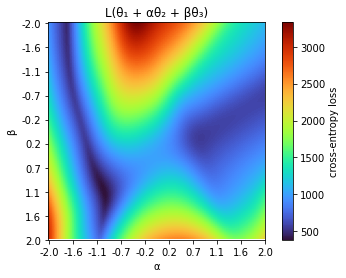

In [308]:
plt.subplots(1, 1, figsize=(6, 4))

plt.imshow(losses, cmap="turbo")
plt.xticks(*get_ticks(space))
plt.yticks(*get_ticks(space))
plt.ylabel("β")
plt.xlabel("α")
plt.title("L(θ₁ + αθ₂ + βθ₃)")

cbar = plt.colorbar()
cbar.set_label("cross-entropy loss")

fig_path = os.path.join(
    usr, "Documents/site/assets/img/loss_map.svg"
)
plt.savefig(fig_path, transparent=True)

plt.show()

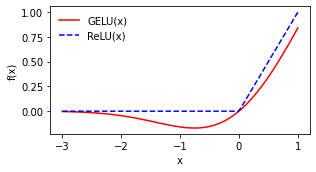

In [44]:
def relu(x):
    return np.maximum(x, 0)


fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))

x = jnp.linspace(-3, 1, 100)
ax.plot(x, gelu(x), color="red", label="GELU(x)")
ax.plot(x, relu(x), color="blue", linestyle="--", label="ReLU(x)")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")

plt.legend(framealpha=0)
plt.tight_layout()

fig_path = os.path.join(
    usr, "Documents/site/assets/img/gelu.svg"
)

plt.savefig(fig_path, transparent=True)
plt.show()